In [5]:
pip install statsmodels matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


/Users/kandanai/anaconda3/envs/04-BE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kandanai/anaconda3/envs/04-BE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kandanai/anaconda3/envs/04-BE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


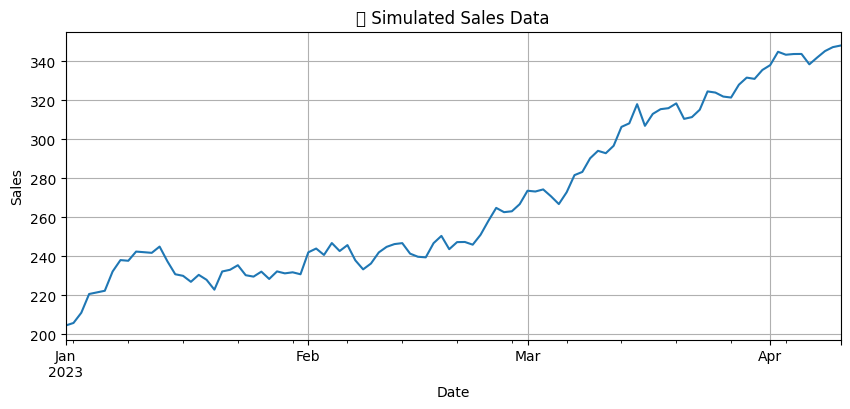

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate trending data
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=100, freq='D')
values = np.cumsum(np.random.normal(loc=2.0, scale=5.0, size=100)) + 200

series = pd.Series(values, index=dates)

# Plot it
series.plot(title="📊 Simulated Sales Data", figsize=(10, 4))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()

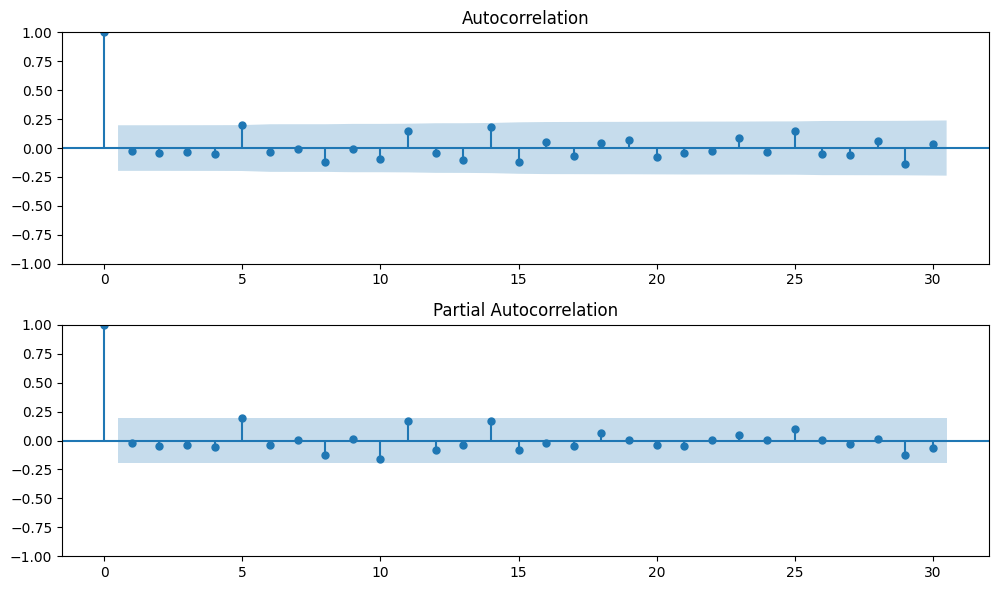

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(series.diff().dropna(), ax=ax[0], lags=30)
plot_pacf(series.diff().dropna(), ax=ax[1], lags=30)
plt.tight_layout()
plt.show()

In [16]:
## Choose d by checking if the data is stationary (we use. diff() to difference)
## Use ACF to estimate q (MA = Moving Average)
## Use PACF to estimate p (AR = Autoregressive)

# Blue shaded are is 95% confidence interval, if a spike goes outside of this area, it is significant
# ACF -> Lag 1 spike, lag2 onwards in bound so q = 1 may be approppriate
# PACF -> Lag 1 spike, lag2 onwards in bound so p = 1 may be approppriate

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,1,1)
# p - PACF, d from first difference of the series, q from ACF
# p - Auto Regression - How many past values to use lags.
# d - Number of time the data needs to be differenced to become stationary.
# q - how many past forecast erros to use.
model = ARIMA(series, order=(1, 1, 1))
model_fit = model.fit()

# Summary of model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -291.708
Date:                Sun, 18 May 2025   AIC                            589.415
Time:                        17:08:10   BIC                            597.201
Sample:                    01-01-2023   HQIC                           592.565
                         - 04-10-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.010    100.139      0.000       0.980       1.020
ma.L1         -0.9993      1.235     -0.809      0.418      -3.420       1.421
sigma2        20.7519     26.017      0.798      0.4

/Users/kandanai/anaconda3/envs/04-BE/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/kandanai/anaconda3/envs/04-BE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


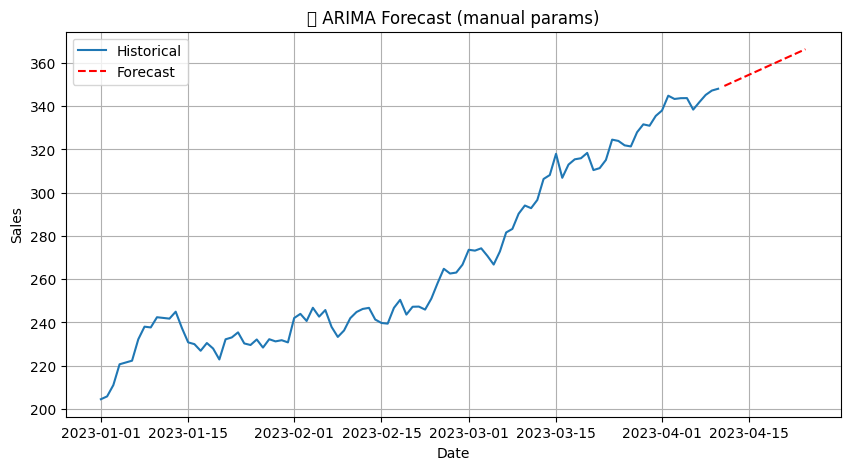

In [18]:
# Forecast next 14 days
n_forecast = 14
forecast = model_fit.forecast(steps=n_forecast)

# Create future index
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=n_forecast)

# Combine with historical data
forecast_series = pd.Series(forecast, index=forecast_index)
combined = pd.concat([series, forecast_series])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(series, label="Historical")
plt.plot(forecast_series, label="Forecast", linestyle='--', color='red')
plt.title("🔮 ARIMA Forecast (manual params)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# arima_manual_forecast.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


print(f"\n🔮 Forecast using model.forecast(): {forecast.iloc[0]:.2f}")

# 4️⃣ Manually calculate 1-step forecast using ARIMA(1,1,1) formula

# Step 1: Get differenced series (d=1)
y_diff = series.diff().dropna()

# Step 2: Get model parameters
phi = model_fit.arparams[0]     # AR(1) coefficient
theta = model_fit.maparams[0]   # MA(1) coefficient
mu = model_fit.params['const'] if 'const' in model_fit.params else 0
print(f"\n📐 Parameters:\nphi={phi:.4f}, theta={theta:.4f}, mu={mu:.4f}")

# Step 3: Get last values
last_y = series.iloc[-1]
last_diff = y_diff.iloc[-1]
last_resid = model_fit.resid.iloc[-1] # Difference between actual and predicted value.

# Step 4: Manually forecast the next differenced value
y_diff_forecast = mu + phi * last_diff + theta * last_resid
## \hat{y}t^{(diff)} = \mu + \phi \cdot y{\prime}{t-1} + \theta \cdot \epsilon_{t-1}
# Step 5: Convert back to original scale by adding to last actual value
y_forecast_manual = last_y + y_diff_forecast
print(f"\n🧮 Manual 1-step Forecast: {y_forecast_manual:.2f}")


🔮 Forecast using model.forecast(): 349.38

📐 Parameters:
phi=1.0000, theta=-0.9993, mu=0.0000

🧮 Manual 1-step Forecast: 349.39


In [20]:
forecast_series

2023-04-11    349.382946
2023-04-12    350.689146
2023-04-13    351.995343
2023-04-14    353.301535
2023-04-15    354.607724
2023-04-16    355.913909
2023-04-17    357.220090
2023-04-18    358.526267
2023-04-19    359.832440
2023-04-20    361.138610
2023-04-21    362.444775
2023-04-22    363.750937
2023-04-23    365.057094
2023-04-24    366.363248
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
# # Get parameters
# phi = model_fit.arparams[0]           # AR(1)
# theta1, theta2 = model_fit.maparams   # MA(1), MA(2)
# mu = model_fit.params.get('const', 0)

# # Get required past values
# last_y = series.iloc[-1]
# last_diff = series.diff().iloc[-1]
# resid = model_fit.resid

# last_resid_1 = resid.iloc[-1]
# last_resid_2 = resid.iloc[-2]

# # Forecast differenced value
# y_diff_forecast = mu + phi * last_diff + theta1 * last_resid_1 + theta2 * last_resid_2

# # Convert to original scale
# y_forecast = last_y + y_diff_forecast
# print(f"Manual ARIMA(1,1,2) forecast: {y_forecast:.2f}")

In [ ]:
# # ARIMA(1,2,1) manual forecast

# # Get model params
# phi = model_fit.arparams[0]
# theta = model_fit.maparams[0]
# mu = model_fit.params.get('const', 0)

# # Compute 2nd order differenced value
# diff_1 = series.diff().dropna()
# diff_2 = diff_1.diff().dropna()

# # Get latest values
# y_t_1 = series.iloc[-1]         # y_{t-1}
# y_t_2 = series.iloc[-2]         # y_{t-2}
# y_ddiff_last = diff_2.iloc[-1]  # y''_{t-1}
# resid_last = model_fit.resid.iloc[-1]  # ε_{t-1}

# # Forecast y''_t
# y_ddiff_forecast = mu + phi * y_ddiff_last + theta * resid_last

# # Reverse differencing: y_t = 2y_{t-1} - y_{t-2} + y''_t
# y_forecast = 2 * y_t_1 - y_t_2 + y_ddiff_forecast

# print(f"🔮 Manual Forecast (ARIMA(1,2,1)): {y_forecast:.2f}")